# PCA Exercise


**Christina Brockway**

## Task:

Compare a default KNeighborsClassifier's speed and performance for a non-PCA dataset and a PCA dataset.

The target for this dataset is 'Diabetes_Risk.' The features are survey responses related to the person's diet. All of the features are numerical.

https://drive.google.com/file/d/1CE2giLLTp0Cjn0bn9hmtCWIxGZf8_uO1/view

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_info_rows', 800)
pd.set_option('display.max_info_columns', 800)

from sklearn import set_config
set_config(transform_output='pandas')

from sklearn.metrics import classification_report, ConfusionMatrixDisplay


In [2]:
#Define Custom Functions

def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
    # Get the classification report
    report = classification_report(y_true, y_pred)
    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)
    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    # create a confusion matrix  of raw counts
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
    axes[0].set_title("Raw Counts")
    # create a confusion matrix with the test data
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")
    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()
    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict


def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
    # Get predictions for training data
    y_train_pred = model.predict(X_train)
    # Call the helper function to obtain regression metrics for training data
    results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
    print()
    # Get predictions for test data
    y_test_pred = model.predict(X_test)
    # Call the helper function to obtain regression metrics for test data
    results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
    if output_dict == True:
        # Store results in a dataframe if ouput_frame is True
        results_dict = {'train':results_train,
                    'test': results_test}
        return results_dict


## Load the Data

In [3]:
data= pd.read_csv('Data/NHANES_Diet_Diabetes_Risk.xls.csv')
data= data.set_index('SEQN')

data.head()

,WTDRD1,WTDR2D,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,DBD100,DRQSPREP,DR1STY,DR1SKY,DRQSDIET,DRQSDT1,DRQSDT2,DRQSDT3,DRQSDT4,DRQSDT5,DRQSDT6,DRQSDT7,DRQSDT8,DRQSDT9,DRQSDT10,DRQSDT11,DRQSDT12,DRQSDT91,DR1TNUMF,DR1TKCAL,DR1TPROT,DR1TCARB,DR1TSUGR,DR1TFIBE,DR1TTFAT,DR1TSFAT,DR1TMFAT,DR1TPFAT,DR1TCHOL,DR1TATOC,DR1TATOA,DR1TRET,DR1TVARA,DR1TACAR,DR1TBCAR,DR1TCRYP,DR1TLYCO,DR1TLZ,DR1TVB1,DR1TVB2,DR1TNIAC,DR1TVB6,DR1TFOLA,DR1TFA,DR1TFF,DR1TFDFE,DR1TCHL,DR1TVB12,DR1TB12A,DR1TVC,DR1TVD,DR1TVK,DR1TCALC,DR1TPHOS,DR1TMAGN,DR1TIRON,DR1TZINC,DR1TCOPP,DR1TSODI,DR1TPOTA,DR1TSELE,DR1TCAFF,DR1TTHEO,DR1TALCO,DR1TMOIS,DR1TS040,DR1TS060,DR1TS080,DR1TS100,DR1TS120,DR1TS140,DR1TS160,DR1TS180,DR1TM161,DR1TM181,DR1TM201,DR1TM221,DR1TP182,DR1TP183,DR1TP184,DR1TP204,DR1TP205,DR1TP225,DR1TP226,DR1.300,DR1.320Z,DR1.330Z,DR1BWATZ,DR1TWS,DRD340,DRD350A,DRD350AQ,DRD350B,DRD350BQ,DRD350C,DRD350CQ,DRD350D,DRD350DQ,DRD350E,DRD350EQ,DRD350F,DRD350FQ,DRD350G,DRD350GQ,DRD350H,DRD350HQ,DRD350I,DRD350IQ,DRD350J,DRD350JQ,DRD350K,DRD360,DRD370A,DRD370AQ,DRD370B,DRD370BQ,DRD370C,DRD370CQ,DRD370D,DRD370DQ,DRD370E,DRD370EQ,DRD370F,DRD370FQ,DRD370G,DRD370GQ,DRD370H,DRD370HQ,DRD370I,DRD370IQ,DRD370J,DRD370JQ,DRD370K,DRD370KQ,DRD370L,DRD370LQ,DRD370M,DRD370MQ,DRD370N,DRD370NQ,DRD370O,DRD370OQ,DRD370P,DRD370PQ,DRD370Q,DRD370QQ,DRD370R,DRD370RQ,DRD370S,DRD370SQ,DRD370T,DRD370TQ,DRD370U,DRD370UQ,DRD370V,Diabetes_Risk
SEQN,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
73557,16888.32786,12930.89065,1,49.0,2.0,2.0,6.0,2.0,1.0,1.0,13.0,3.0,2.0,4.0,2.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,1574.0,43.63,239.59,176.47,10.8,52.81,17.819,18.493,8.829,209.0,3.92,0.0,70.0,110.0,60.0,304.0,278.0,1398.0,430.0,1.057,1.216,11.804,0.951,285.0,66.0,219.0,330.0,216.3,2.79,0.00,241.4,3.3,29.2,949.0,756.0,206.0,8.41,8.85,1.072,1323.0,2228.0,62.5,203.0,36.0,0.0,2701.79,0.219,0.099,0.103,0.153,0.346,1.221,9.694,5.408,1.173,16.796,0.121,0.001,7.932,0.769,0.000,0.094,0.001,0.000,0.010,2.0,960.0,960.0,0.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
73558,17932.14387,12684.14887,1,59.0,2.0,2.0,4.0,1.0,1.0,1.0,13.0,1.0,2.0,3.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,5062.0,338.13,423.78,44.99,16.7,124.29,53.408,35.481,20.505,2584.0,20.94,0.0,1477.0,1488.0,0.0,145.0,12.0,0.0,899.0,4.178,5.168,65.396,4.415,1243.0,601.0,641.0,1662.0,2149.0,21.45,0.00,2.3,15.2,23.4,3193.0,6427.0,903.0,26.88,30.36,4.130,9726.0,4930.0,715.8,240.0,0.0,119.0,6779.99,1.872,1.160,0.802,1.286,1.297,6.516,27.952,12.107,2.208,32.429,0.086,0.000,15.483,1.774,0.007,0.728,1.003,0.104,1.139,2.0,360.0,360.0,0.0,1.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,1.0,1.0,1.0,1.0,2.0,NaN,2.0,NaN,2.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,1.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,2
73559,59641.81293,39394.23671,1,49.0,2.0,2.0,18.0,6.0,1.0,1.0,13.0,1.0,1.0,2.0,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,27.0,1743.0,64.61,224.39,102.90,9.9,65.97,25.263,20.902,12.953,88.0,8.87,0.0,616.0,655.0,21.0,449.0,35.0,515.0,300.0,1.648,1.747,18.342,1.906,423.0,290.0,133.0,625.0,161.2,3.78,1.42,195.1,4.0,40.4,877.0,1198.0,210.0,17.57,8.98,0.949,2943.0,1694.0,98.3,45.0,71.0,0.0,3766.70,0.358,0.128,0.371,0.455,3.008,2.067,10.691,7.497,0.531,19.910,0.164,0.005,11.705,1.092,0.000,0.042,0.001,0.006,0.002,2.0,1254.0,0.0,1254.0,1.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,1.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [4]:
 #Check for duplicates
data.duplicated().sum()

511

In [5]:
df=data.drop_duplicates(keep='first')
df.duplicated().sum()

0

In [6]:
#Check for nulls
df.isna().sum()

WTDRD1              0
WTDR2D             48
DR1DRSTZ            0
DR1EXMER            7
DRABF              48
                 ... 
DRD370TQ         5153
DRD370U          2154
DRD370UQ         5862
DRD370V          2155
Diabetes_Risk       0
Length: 168, dtype: int64

In [7]:
df['DRQSDT5'].isna().sum()

6132

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6132 entries, 73557 to 83729
Data columns (total 168 columns):
 #    Column         Dtype  
---   ------         -----  
 0    WTDRD1         float64
 1    WTDR2D         float64
 2    DR1DRSTZ       int64  
 3    DR1EXMER       float64
 4    DRABF          float64
 5    DRDINT         float64
 6    DR1DBIH        float64
 7    DR1DAY         float64
 8    DR1LANG        float64
 9    DR1MNRSP       float64
 10   DR1HELPD       float64
 11   DBQ095Z        float64
 12   DBD100         float64
 13   DRQSPREP       float64
 14   DR1STY         float64
 15   DR1SKY         float64
 16   DRQSDIET       float64
 17   DRQSDT1        float64
 18   DRQSDT2        float64
 19   DRQSDT3        float64
 20   DRQSDT4        float64
 21   DRQSDT5        float64
 22   DRQSDT6        float64
 23   DRQSDT7        float64
 24   DRQSDT8        float64
 25   DRQSDT9        float64
 26   DRQSDT10       float64
 27   DRQSDT11       float64
 28   DRQSDT12   

In [9]:
df.describe()

,WTDRD1,WTDR2D,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,DBD100,DRQSPREP,DR1STY,DR1SKY,DRQSDIET,DRQSDT1,DRQSDT2,DRQSDT3,DRQSDT4,DRQSDT5,DRQSDT6,DRQSDT7,DRQSDT8,DRQSDT9,DRQSDT10,DRQSDT11,DRQSDT12,DRQSDT91,DR1TNUMF,DR1TKCAL,DR1TPROT,DR1TCARB,DR1TSUGR,DR1TFIBE,DR1TTFAT,DR1TSFAT,DR1TMFAT,DR1TPFAT,DR1TCHOL,DR1TATOC,DR1TATOA,DR1TRET,DR1TVARA,DR1TACAR,DR1TBCAR,DR1TCRYP,DR1TLYCO,DR1TLZ,DR1TVB1,DR1TVB2,DR1TNIAC,DR1TVB6,DR1TFOLA,DR1TFA,DR1TFF,DR1TFDFE,DR1TCHL,DR1TVB12,DR1TB12A,DR1TVC,DR1TVD,DR1TVK,DR1TCALC,DR1TPHOS,DR1TMAGN,DR1TIRON,DR1TZINC,DR1TCOPP,DR1TSODI,DR1TPOTA,DR1TSELE,DR1TCAFF,DR1TTHEO,DR1TALCO,DR1TMOIS,DR1TS040,DR1TS060,DR1TS080,DR1TS100,DR1TS120,DR1TS140,DR1TS160,DR1TS180,DR1TM161,DR1TM181,DR1TM201,DR1TM221,DR1TP182,DR1TP183,DR1TP184,DR1TP204,DR1TP205,DR1TP225,DR1TP226,DR1.300,DR1.320Z,DR1.330Z,DR1BWATZ,DR1TWS,DRD340,DRD350A,DRD350AQ,DRD350B,DRD350BQ,DRD350C,DRD350CQ,DRD350D,DRD350DQ,DRD350E,DRD350EQ,DRD350F,DRD350FQ,DRD350G,DRD350GQ,DRD350H,DRD350HQ,DRD350I,DRD350IQ,DRD350J,DRD350JQ,DRD350K,DRD360,DRD370A,DRD370AQ,DRD370B,DRD370BQ,DRD370C,DRD370CQ,DRD370D,DRD370DQ,DRD370E,DRD370EQ,DRD370F,DRD370FQ,DRD370G,DRD370GQ,DRD370H,DRD370HQ,DRD370I,DRD370IQ,DRD370J,DRD370JQ,DRD370K,DRD370KQ,DRD370L,DRD370LQ,DRD370M,DRD370MQ,DRD370N,DRD370NQ,DRD370O,DRD370OQ,DRD370P,DRD370PQ,DRD370Q,DRD370QQ,DRD370R,DRD370RQ,DRD370S,DRD370SQ,DRD370T,DRD370TQ,DRD370U,DRD370UQ,DRD370V,Diabetes_Risk
count,6132.000000,6084.000000,6132.000000,6125.000000,6084.0,6084.000000,6066.000000,6125.000000,6129.000000,6082.000000,6082.000000,6125.000000,4361.000000,6125.000000,6125.000000,1256.000000,6125.000000,482.0,121.0,112.0,34.0,0.0,2.0,137.0,17.0,60.0,21.0,25.0,7.0,50.0,6084.000000,6084.000000,6084.000000,6084.000000,6084.000000,6084.000000,6084.000000,6084.000000,6084.000000,6084.000000,6084.000000,6084.000000,6084.000000,6084.000000,6084.000000,6084.000000,6084.000000,6084.000000,6084.000000,6084.000000,6084.000000,6084.000000,6084.000000,6084.000000,6084.000000,6084.000000,6084.000000,6084.000000,6084.000000,6084.000000,6084.000000,6084.000000,6084.000000,6084.000000,6084.000000,6084.000000,6084.000000,6084.000000,6084.000000,6084.000000,6084.000000,6084.000000,6084.000000,6084.000000,6084.000000,6084.000000,6084.000000,6084.000000,6084.000000,6084.000000,6084.000000,6084.000000,6084.000000,6084.000000,6084.000000,6084.000000,6084.000000,6084.000000,6084.000000,6084.000000,6084.000000,6084.000000,6084.000000,6084.000000,6084.000000,6084.000000,6125.000000,6084.000000,6084.000000,6084.000000,6125.000000,6127.000000,3023.000000,382.000000,3023.000000,642.000000,3023.000000,159.000000,3023.000000,370.000000,3023.000000,234.000000,3023.000000,264.000000,3023.000000,330.000000,3023.000000,2627.000000,3023.000000,191.000000,3023.000000,15.000000,3022.0,6127.000000,3978.000000,446.000000,3978.000000,1542.000000,3978.000000,100.000000,3978.000000,671.000000,3978.000000,482.000000,3978.000000,228.000000,3978.000000,163.000000,3978.000000,84.000000,3978.000000,82.000000,3978.000000,10.000000,3978.000000,121.000000,3978.000000,31.000000,3978.000000,1448.000000,3978.000000,191.000000,3978.000000,78.000000,3978.000000,8.000000,3978.000000,56.000000,3978.000000,152.000000,3978.000000,23.000000,3978.000000,979.000000,3978.000000,270.000000,3977.0,6132.000000
mean,41482.114679,41861.363788,1.011252,43.631510,2.0,1.888231,15.956973,4.460245,1.152553,1.044229,12.857448,3.517061,1.709012,3.209633,1.845224,2.026274,1.888490,1.0,2.0,3.0,4.0,NaN,6.0,7.0,8.0,9.0,10.0,11.0,12.0,91.0,15.478139,2102.017094,81.700684,253.879837,111.529502,16.584073,80.766558,26.009202,28.093987,18.988610,293.123439,8.816266,0.776673,409.212032,598.374425,364.395957,2052.473208,87.938692,4810.433103,1489.349277,1.600289,2.056730,25.797053,2.105743,395.090565,181.402038,213.650559,521.997370,328.726266,4.882584,1.069974,79.221335,4.675740,111.767982,939.487344,1359.353879,289.433432,14.405605,10.909689,1.177981,3482.678994,2527.860125,115.674310,123.960552,37.79405

In [10]:
target = 'Diabetes_Risk'
drop_cols=[target,'DRQSDT5']
y=df[target].copy()
X=df.drop(columns=drop_cols).copy()

In [11]:
#TTS
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4599 entries, 81475 to 75027
Data columns (total 166 columns):
 #    Column    Dtype  
---   ------    -----  
 0    WTDRD1    float64
 1    WTDR2D    float64
 2    DR1DRSTZ  int64  
 3    DR1EXMER  float64
 4    DRABF     float64
 5    DRDINT    float64
 6    DR1DBIH   float64
 7    DR1DAY    float64
 8    DR1LANG   float64
 9    DR1MNRSP  float64
 10   DR1HELPD  float64
 11   DBQ095Z   float64
 12   DBD100    float64
 13   DRQSPREP  float64
 14   DR1STY    float64
 15   DR1SKY    float64
 16   DRQSDIET  float64
 17   DRQSDT1   float64
 18   DRQSDT2   float64
 19   DRQSDT3   float64
 20   DRQSDT4   float64
 21   DRQSDT6   float64
 22   DRQSDT7   float64
 23   DRQSDT8   float64
 24   DRQSDT9   float64
 25   DRQSDT10  float64
 26   DRQSDT11  float64
 27   DRQSDT12  float64
 28   DRQSDT91  float64
 29   DR1TNUMF  float64
 30   DR1TKCAL  float64
 31   DR1TPROT  float64
 32   DR1TCARB  float64
 33   DR1TSUGR  float64
 34   DR1TFIBE  float64

In [12]:
#instantiate preprocessors
impute_median = SimpleImputer(strategy = 'median')
scaler = StandardScaler()
preprocessor =  make_pipeline(impute_median, scaler)

In [13]:
X_train_tf = preprocessor.fit_transform(X_train)
X_test_tf = preprocessor.transform(X_test)

In [14]:
#Check for imbalance
#y_train.value_counts(1)

In [15]:
#from imblearn.over_sampling import SMOTE, SMOTENC

#smote=SMOTE()
#X_train_sm, y_train_sm = smote.fit_resample(X_train_tf, y_train)
#y_train_sm.value_counts()

In [16]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()

knn_pipe = make_pipeline(preprocessor, knn)

knn_pipe.fit(X_train_tf, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('simpleimputer',
                                  SimpleImputer(strategy='median')),
                                 ('standardscaler', StandardScaler())])),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [18]:
%%time
preds = knn.predict(X_test_tf)

CPU times: total: 547 ms
Wall time: 101 ms


----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.99      0.91      3766
           1       0.49      0.07      0.12       412
           2       0.63      0.06      0.11       421

    accuracy                           0.83      4599
   macro avg       0.65      0.37      0.38      4599
weighted avg       0.78      0.83      0.76      4599



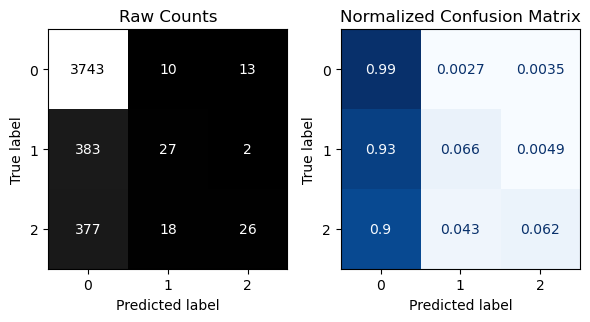


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.98      0.91      1291
           1       0.06      0.01      0.01       120
           2       0.08      0.01      0.01       122

    accuracy                           0.83      1533
   macro avg       0.33      0.33      0.31      1533
weighted avg       0.72      0.83      0.77      1533



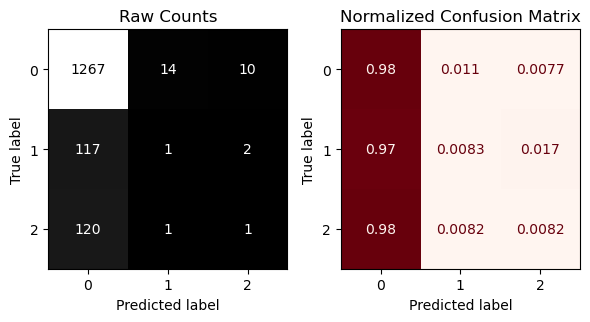

In [20]:
evaluate_classification(knn, X_train_tf,y_train, X_test_tf, y_test)


## Transform Data with PCA

In [21]:
 #Instantiate Standard Scaler
scaler = StandardScaler()
# Fit & transform data.
X_train_scaled = scaler.fit_transform(X_train_tf)
X_test_scaled = scaler.transform(X_test_tf)

In [22]:
pca = PCA(n_components=.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


#### 98 Principal components were created

In [23]:
knn_pca = knn_pipe.fit(X_train_pca, y_train)

In [24]:
%%time
preds_pca = knn_pca.predict(X_test_pca)

CPU times: total: 484 ms
Wall time: 89 ms


----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.99      0.90      3766
           1       0.59      0.08      0.15       412
           2       0.69      0.06      0.11       421

    accuracy                           0.83      4599
   macro avg       0.70      0.38      0.39      4599
weighted avg       0.80      0.83      0.76      4599



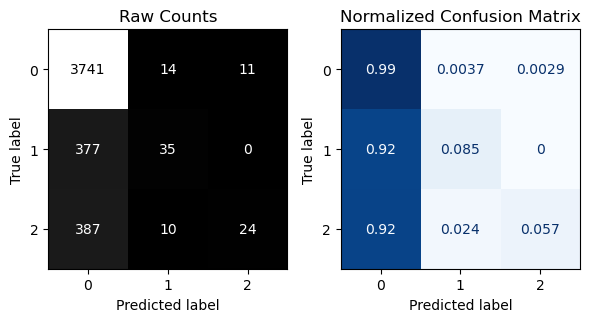


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.99      0.91      1291
           1       0.00      0.00      0.00       120
           2       0.00      0.00      0.00       122

    accuracy                           0.83      1533
   macro avg       0.28      0.33      0.30      1533
weighted avg       0.71      0.83      0.77      1533



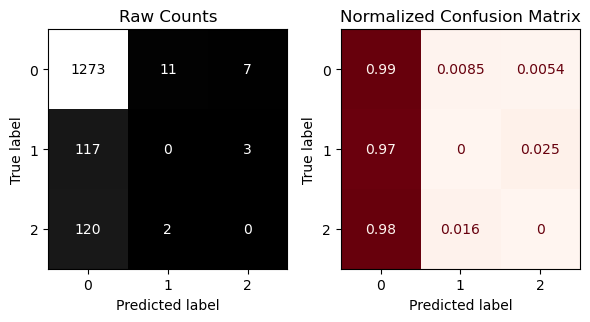

In [25]:
evaluate_classification(knn, X_train_pca, y_train, X_test_pca, y_test)


In [ ]:
# Compare speeds before and after PCA
compare_speed = preds/preds_pca
#print(f"Using PCs was {compare_speed:.2f} times faster!")


***Q1. How many features were used in the first model, and how many PCs were used in the PCA model?***

**There were 166 features used in the first model, and 98 PCs were used in the PCA model.**

***Q2. Which model performed the best on the test set?***

**The PCA model performed the best on the test set**

***Q3. Which model was the fastest at making predictions?***

**The PCA model had the fastest times with CPU times at 484 ms and 
Wall tie at: 89 m, where the other model had times at 587ms and 101ms respectively.**s